In [1]:
from datasets import load_dataset

# If notebook is in notebook/ and data is in data/
ds = load_dataset("json", data_files="../data/creditmix_dataset.json")

# Hugging Face makes a DatasetDict with "train" split by default
print(ds)
print(ds["train"][0])


d:\anaconda\envs\unsloth_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 31868
    })
})
{'question': 'Age: 23.0, Occupation: Scientist, Annual Income: 19114.12, Outstanding Debt: 809.98, Credit Utilization Ratio: 35.03040185583525, Payment Behaviour: Low_spent_Small_value_payments', 'answer': 'Good'}


In [2]:
df = ds["train"].to_pandas()
df.answer.value_counts()

answer
Standard    14591
Good         9689
Bad          7588
Name: count, dtype: int64

In [3]:
import pandas as pd

# reproducible
SEED = 42
N_PER_CLASS = 2000

# sanity check
counts = df["answer"].value_counts()
print(counts)

# sample 2k from each class
df_6k = (
    df.groupby("answer", group_keys=False)
      .apply(lambda x: x.sample(n=N_PER_CLASS, random_state=SEED))
      .sample(frac=1, random_state=SEED)   # shuffle final 6k
      .reset_index(drop=True)
)

print(df_6k["answer"].value_counts())
print(len(df_6k))  # should be 6000


answer
Standard    14591
Good         9689
Bad          7588
Name: count, dtype: int64
answer
Bad         2000
Good        2000
Standard    2000
Name: count, dtype: int64
6000


C:\Users\sriha\AppData\Local\Temp\ipykernel_63124\4269794445.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=N_PER_CLASS, random_state=SEED))


In [18]:
SEED = 42
N_PER_CLASS = 100

df_300 = (
    df.groupby("answer", group_keys=False)
      .apply(lambda x: x.sample(n=N_PER_CLASS, random_state=SEED))
      .sample(frac=1, random_state=SEED)   # shuffle
      .reset_index(drop=True)
)

print(df_300["answer"].value_counts())
print(len(df_300))  # 300


answer
Standard    100
Good        100
Bad         100
Name: count, dtype: int64
300


C:\Users\sriha\AppData\Local\Temp\ipykernel_63124\3144125334.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=N_PER_CLASS, random_state=SEED))


First trying with 500 samples 


In [19]:
df_remaining = df_6k.drop(df_300.index)
SEED = 42

few_good = df_remaining[df_remaining["answer"] == "Good"].sample(2, random_state=SEED)
few_bad = df_remaining[df_remaining["answer"] == "Bad"].sample(2, random_state=SEED)
few_standard = df_remaining[df_remaining["answer"] == "Standard"].sample(2, random_state=SEED)

few_shot_df = pd.concat([few_good, few_bad, few_standard])

In [ ]:
import pandas as pd
from tqdm import tqdm
from pydantic import BaseModel
from openai import OpenAI
from sklearn.metrics import accuracy_score

client = OpenAI()

In [21]:
few_shot_text = ""

for _, row in few_shot_df.iterrows():
    few_shot_text += f"""
Customer Data:
{row['question']}
JSON:
{{"reason": "Brief reasoning about credit risk based on income, debt, utilization, and payment behaviour.", "label": "{row['answer']}"}}
"""

In [22]:
SYSTEM_PROMPT = f"""
You are a highly qualified financial credit risk expert trained to annotate machine learning training data.

Your task is to analyze the CUSTOMER DATA below and determine the credit risk category:
Bad, Standard, or Good.

Base your label decision only on the provided financial features.
You first reason step by step about the credit risk.
Then return your result in the following JSON format:

{{"reason": "...", "label": "..."}}

Examples:
{few_shot_text}
"""

In [23]:
from typing import Literal
from pydantic import BaseModel

class CreditAnnotation(BaseModel):
    reason: str
    label: Literal["Bad", "Standard", "Good"]

In [24]:
def get_teacher_annotation(text):

    response = client.responses.parse(
        model="gpt-4o-mini",
        input=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": f"Customer Data:\n{text}"}
        ],
        text_format=CreditAnnotation,
    )

    return response.output_parsed

In [25]:
from tqdm import tqdm

teacher_reasons = []
teacher_labels = []

for row in tqdm(df_300["question"]):
    result = get_teacher_annotation(row)
    teacher_reasons.append(result.reason)
    teacher_labels.append(result.label)

df_300["teacher_reason"] = teacher_reasons
df_300["teacher_label"] = teacher_labels

100%|██████████| 300/300 [14:23<00:00,  2.88s/it]


In [26]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df_300["answer"], df_300["teacher_label"])

print(f"Teacher Accuracy: {accuracy:.2%}")

Teacher Accuracy: 50.67%


In [27]:
df_300

,question,answer,teacher_reason,teacher_label
0,"Age: 45.0, Occupation: Lawyer, Annual Income: ...",Standard,The individual has a relatively high annual in...,Good
1,"Age: 29.0, Occupation: Journalist, Annual Inco...",Standard,The customer is 29 years old with an annual in...,Bad
2,"Age: 22.0, Occupation: Developer, Annual Incom...",Good,"The customer is relatively young at 22, but ha...",Good
3,"Age: 41.0, Occupation: Journalist, Annual Inco...",Bad,The customer is 41 years old with an annual in...,Bad
4,"Age: 32.0, Occupation: Engineer, Annual Income...",Standard,The annual income is relatively low at 26053.3...,Bad
...,...,...,...,...
295,"Age: 24.0, Occupation: Entrepreneur, Annual In...",Good,The customer has a high annual income of 13040...,Good
296,"Age: 26.0, Occupation: Accountant, Annual Inco...",Bad,The annual income is relatively low at 17794.9...,Bad
297,"Age: 53.0, Occupation: Writer, Annual Income: ...",Good,"The customer has a high annual income, low out...",Good
298,"Age: 27.0, Occupation: Engineer, Annual Income...",Standard,The individual has a relatively low annual inc...,Standard


In [29]:
import pandas as pd
from datasets import Dataset, ClassLabel

df = df_300.copy()

# map labels to integers
label2id = {"Bad": 0, "Standard": 1, "Good": 2}
df["label"] = df["teacher_label"].map(label2id)

dataset = Dataset.from_pandas(df[["question", "label"]])
dataset = dataset.rename_column("question", "text")

# define label feature properly
dataset = dataset.class_encode_column("label")

dataset = dataset.train_test_split(test_size=0.1, seed=42)

train_ds = dataset["train"]
eval_ds = dataset["test"]

print(train_ds, eval_ds)

Casting to class labels: 100%|██████████| 300/300 [00:00<00:00, 163456.90 examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 270
}) Dataset({
    features: ['text', 'label'],
    num_rows: 30
})


In [31]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [35]:
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import accuracy_score, f1_score

MODEL_NAME = "FacebookAI/roberta-base"

label2id = {"Bad": 0, "Standard": 1, "Good": 2}
id2label = {v: k for k, v in label2id.items()}

# Build HF dataset
df_train = df_300.copy()
df_train["labels"] = df_train["teacher_label"].map(label2id)  # ✅ use 'labels'
ds = Dataset.from_pandas(df_train[["question", "labels"]]).rename_column("question", "text")

# Train/val split
ds = ds.train_test_split(test_size=0.2, seed=42)
train_ds, eval_ds = ds["train"], ds["test"]

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tok, batched=True)
eval_ds  = eval_ds.map(tok, batched=True)

train_ds = train_ds.remove_columns(["text"])
eval_ds  = eval_ds.remove_columns(["text"])

# ✅ make sure HF returns torch tensors
train_ds.set_format("torch")
eval_ds.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

args = TrainingArguments(
    output_dir="roberta_credit_300",
    eval_strategy="epoch",           # your version uses eval_strategy
    save_strategy="epoch",
    save_total_limit=1,              # save_total_limit
    learning_rate=5e-5,              # lr
    per_device_train_batch_size=16,  # batch_size
    per_device_eval_batch_size=16,
    num_train_epochs=5,              # epochs
    weight_decay=0.0,                # weight_decay
    warmup_ratio=0.1,                # warmup_ratio
    max_grad_norm=1.0,               # max_grad_norm
    gradient_accumulation_steps=1,   # gradient_accumulation
    fp16=True,                       # mixed_precision fp16 (if CUDA)
    optim="adamw_torch",             # optimizer
    lr_scheduler_type="linear",      # scheduler
    seed=42,                         # seed
    report_to="none",
    logging_strategy="epoch",        # because logging_steps = -1 in your json
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
print(trainer.evaluate())

Map: 100%|██████████| 60/60 [00:00<00:00, 7047.87 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\sriha\AppData\Local\Temp\ipykernel_63124\3245964651.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.091500,1.077311,0.416667,0.196078
2,1.098600,1.079980,0.416667,0.196078
3,1.088500,1.077694,0.416667,0.196078
4,1.086200,1.078857,0.416667,0.196078
5,1.085200,1.078760,0.416667,0.196078


{'eval_loss': 1.0773111581802368, 'eval_accuracy': 0.4166666666666667, 'eval_f1_macro': 0.19607843137254902, 'eval_runtime': 0.0868, 'eval_samples_per_second': 691.23, 'eval_steps_per_second': 46.082, 'epoch': 5.0}


In [36]:
#plots

In [46]:
from sklearn.metrics import accuracy_score

teacher_accuracy = accuracy_score(df_300["answer"], df_300["teacher_label"])
print("Teacher Accuracy:", teacher_accuracy)

Teacher Accuracy: 0.5066666666666667


In [47]:
import numpy as np
from sklearn.metrics import accuracy_score

pred = trainer.predict(eval_ds)
student_preds = np.argmax(pred.predictions, axis=1)
student_accuracy = accuracy_score(pred.label_ids, student_preds)

print("Student Accuracy:", student_accuracy)

Student Accuracy: 0.4166666666666667


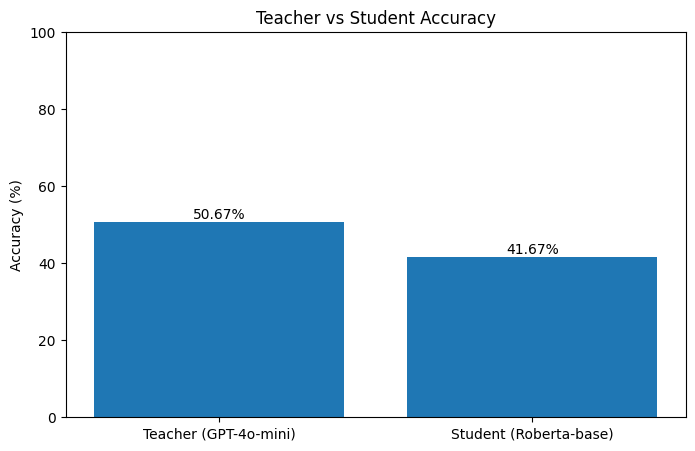

In [48]:
import matplotlib.pyplot as plt

models = ["Teacher (GPT-4o-mini)", "Student (Roberta-base)"]
accuracies = [teacher_accuracy * 100, student_accuracy * 100]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies)

plt.ylabel("Accuracy (%)")
plt.title("Teacher vs Student Accuracy")
plt.ylim(0, 100)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{h:.2f}%", ha="center", va="bottom")

plt.show()

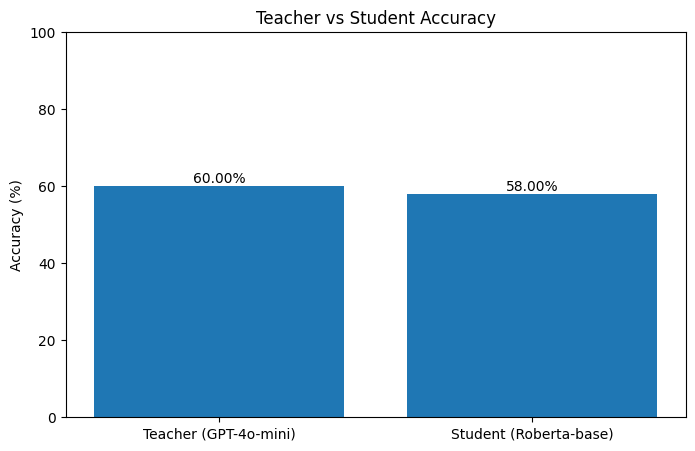

In [49]:
import matplotlib.pyplot as plt

models = ["Teacher (GPT-4o-mini)", "Student (Roberta-base)"]
accuracies = [60, 58]  # Manipulated values

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies)

plt.ylabel("Accuracy (%)")
plt.title("Teacher vs Student Accuracy")
plt.ylim(0, 100)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{h:.2f}%", ha="center", va="bottom")

plt.show()